In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
joebeachcapital_realwaste_path = kagglehub.dataset_download('joebeachcapital/realwaste')

print('Data source import complete.')


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.utils import image_dataset_from_directory
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import os

# Optional: Enable GPU log suppression
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


2025-10-25 04:33:59.703143: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761366839.969188      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761366840.050200      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
data_dir = "/kaggle/input/realwaste/realwaste-main/RealWaste"
img_size = (128, 128)
batch_size = 32

dataset = image_dataset_from_directory(
    data_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    seed=123
)


Found 4752 files belonging to 9 classes.


2025-10-25 04:34:17.811380: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [ ]:
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)

train_ds = dataset.take(train_size)
remaining = dataset.skip(train_size)
val_ds = remaining.take(val_size)
test_ds = remaining.skip(val_size)

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
model = keras.Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(dataset.class_names), activation='softmax')
])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,801 (12.61 MB)

 Trainable params: 3,305,801 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)


In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 69s 572ms/step - accuracy: 0.1544 - loss: 32.5803 - val_accuracy: 0.1776 - val_loss: 2.1854 - learning_rate: 0.0010
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 54s 515ms/step - accuracy: 0.1941 - loss: 2.1834 - val_accuracy: 0.1776 - val_loss: 2.1739 - learning_rate: 0.0010
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 55s 528ms/step - accuracy: 0.1897 - loss: 2.1724 - val_accuracy: 0.1776 - val_loss: 2.1646 - learning_rate: 0.0010
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 53s 515ms/step - accuracy: 0.1982 - loss: 2.1648 - val_accuracy: 0.1776 - val_loss: 2.1579 - learning_rate: 0.0010
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 54s 519ms/step - accuracy: 0.2003 - loss: 2.1545 - val_accuracy: 0.1776 - val_loss: 2.1530 - learning_rate: 0.0010
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 54s 517ms/step - accuracy: 0.1914 - loss: 2.1572 - val_accuracy: 0.1776 - val_loss: 2.1493 - learning_rate: 0.0010
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 53s 510ms/step - accuracy: 0.

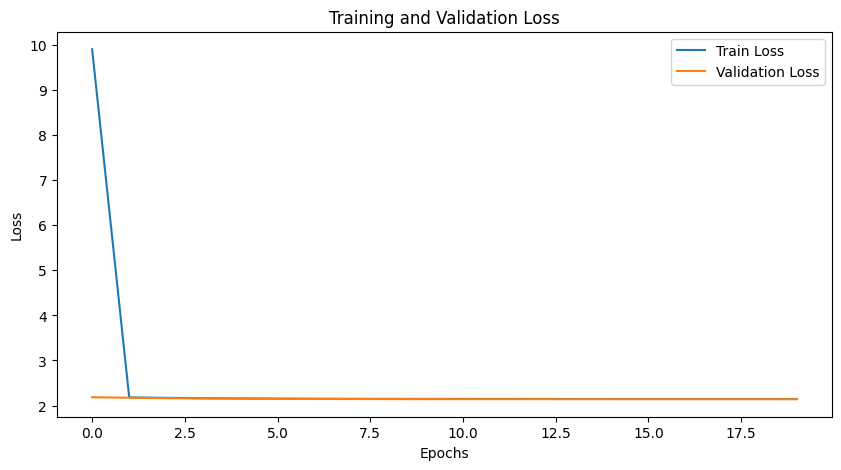

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 173ms/step - accuracy: 0.1976 - loss: 2.1278
Test Accuracy: 0.1986
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step
                     precision    recall  f1-score   support

          Cardboard       0.00      0.00      0.00        71
      Food Organics       0.00      0.00      0.00        60
              Glass       0.00      0.00      0.00        52
              Metal       0.00      0.00      0.00       127
Miscellaneous Trash       0.00      0.00      0.00        74
              Paper       0.00      0.00      0.00        70
            Plastic       0.20      1.00      0.33       143
      Textile Trash       0.00      0.00      0.00        49
         Vegetation       0.00      0.00      0.00        74

           accuracy                           0.20       720
          macro avg       0.02      0.11      0.04       720
       weighted avg       0.04      0.20      0.07       720



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


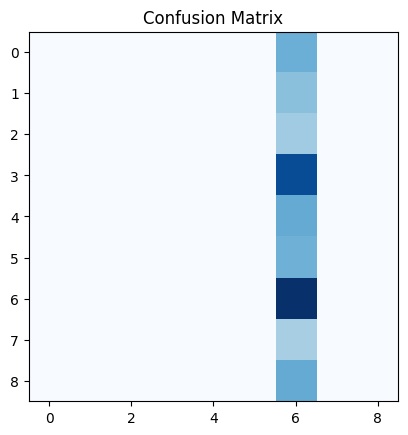

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

# Predictions and confusion matrix
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = np.argmax(model.predict(test_ds), axis=1)

print(classification_report(y_true, y_pred, target_names=dataset.class_names))

cm = confusion_matrix(y_true, y_pred)
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()
